In [104]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf


import requests
import json


In [105]:
 #df = pd.read_csv(r'D:\screener_project\ai_bots\lstm_predictor\AAPL.csv')
# df.head()
tickerHistoryResponse = requests.get("https://financialmodelingprep.com/api/v3/"+"historical-price-full/"+"AAPL"+"?apikey="+"56e431b750c849dd5d42c5c0443186fc")
dailyHistory=tickerHistoryResponse.json()['historical'][::-1]
df = pd.DataFrame(dailyHistory)
df.head()

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2016-04-06,27.557501,27.745001,27.299999,27.740000,25.839775,105616400.0,105616400.0,0.1825,0.662,27.59500,"April 06, 16",0.00662
1,2016-04-07,27.487499,27.605000,27.030001,27.135000,25.276215,127207600.0,127207600.0,-0.3525,-1.282,27.25667,"April 07, 16",-0.01282
2,2016-04-08,27.227501,27.442499,27.042500,27.165001,25.304159,94326800.0,94326800.0,-0.0625,-0.230,27.21667,"April 08, 16",-0.00230
3,2016-04-11,27.242500,27.652500,27.207500,27.254999,25.387993,117630000.0,117630000.0,0.0125,0.046,27.37167,"April 11, 16",0.00046
4,2016-04-12,27.334999,27.625000,27.165001,27.610001,25.718679,108929200.0,108929200.0,0.2750,1.006,27.46667,"April 12, 16",0.01006


In [106]:
#preprocessing our data
df = df['open'].values
df = df.reshape(-1,1)
print(df.shape)
df[:7]

(1258, 1)


array([[27.557501],
       [27.487499],
       [27.227501],
       [27.2425  ],
       [27.334999],
       [27.700001],
       [27.905001]])

In [107]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1006, 1)
(302, 1)


In [108]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:7]

array([[0.08618047],
       [0.08498763],
       [0.08055723],
       [0.08081282],
       [0.08238901],
       [0.08860869],
       [0.09210192]])

In [109]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:7]

array([[0.97094666],
       [0.98087249],
       [0.93746274],
       [0.94828327],
       [0.99876468],
       [0.98210793],
       [0.98376928]])

In [110]:
def create_my_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [111]:
x_train, y_train = create_my_dataset(dataset_train)
x_train[:1]

array([[0.08618047, 0.08498763, 0.08055723, 0.08081282, 0.08238901,
        0.08860869, 0.09210192, 0.09418932, 0.08047201, 0.07616936,
        0.07088694, 0.07212235, 0.06394311, 0.06390049, 0.05925707,
        0.0255602 , 0.03241885, 0.01699751, 0.01691233, 0.01789212,
        0.02215215, 0.01704013, 0.01435633, 0.0127801 , 0.01418591,
        0.01482493, 0.01158729, 0.        , 0.01018148, 0.01938317,
        0.01772175, 0.01976655, 0.01976655, 0.02500641, 0.03075743,
        0.03693448, 0.04123711, 0.04021472, 0.04089631, 0.03842548,
        0.03237625, 0.03318565, 0.03403764, 0.0394053 , 0.03842548,
        0.03621028, 0.03633808, 0.0370197 , 0.03118344, 0.03331345]])

In [112]:
y_train[:1]

array([0.02747719])

In [113]:
x_test, y_test = create_my_dataset(dataset_test)
x_test[:1]

array([[0.97094666, 0.98087249, 0.93746274, 0.94828327, 0.99876468,
        0.98210793, 0.98376928, 0.91292492, 0.95982791, 0.99480274,
        0.9907558 , 0.98990374, 0.95501406, 0.99514363, 0.98606973,
        0.99765703, 1.        , 0.96004086, 0.97980748, 0.99101138,
        0.97392862, 0.88293437, 0.89865391, 0.83722419, 0.81409225,
        0.71253307, 0.81911905, 0.9102412 , 0.87944113, 0.87552183,
        0.81792624, 0.74018065, 0.79722255, 0.79828756, 0.70690981,
        0.74503716, 0.64731192, 0.67099771, 0.63802509, 0.67048652,
        0.66959188, 0.58822529, 0.62349836, 0.68480023, 0.66678031,
        0.69332029, 0.68475764, 0.70546142, 0.66669509, 0.64045327]])

In [114]:
#reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(956, 50, 1)
(252, 50, 1)


In [115]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [116]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_14 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [117]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [118]:
if(not os.path.exists(r'D:\screener_project\ai_bots\lstm_predictor\stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save(r'D:\screener_project\ai_bots\lstm_predictor\stock_prediction.h5')

Epoch 1/50
30/30 [==============================] - 5s 31ms/step - loss: 0.0440
Epoch 2/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0032
Epoch 3/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0039
Epoch 4/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0028
Epoch 5/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0025
Epoch 6/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0025
Epoch 7/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0025
Epoch 8/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0020
Epoch 9/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0019
Epoch 10/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0022
Epoch 11/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0022
Epoch 12/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0021
Epoch 13/50
30/30 [==================

In [119]:
model = load_model(r'D:\screener_project\ai_bots\lstm_predictor\stock_prediction.h5')

range(1006, 1258)


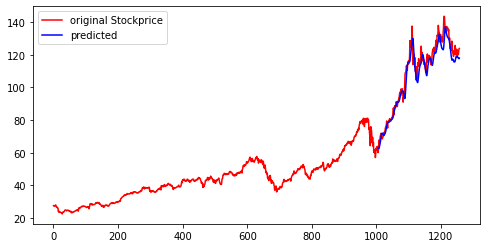

In [120]:
#visualizing our predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

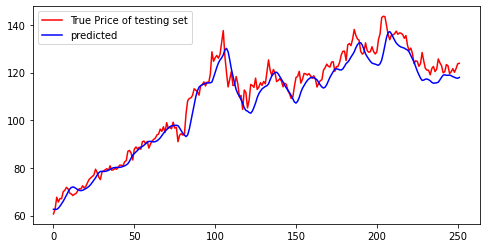

In [121]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='predicted')
plt.legend()